# Customer Churn Prediction - Music Streaming Service

This notebook analyzes user behavior data to predict customer churn in a music streaming service similar to Spotify.

## Setup and Data Loading

In [ ]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

## Data Loading

First, we need to load the event data. Please ensure the JSON file is placed in the project directory.

In [ ]:
# Load the data
file_path = r"C:\Users\poosa\OneDrive\Desktop\mini_sparkify_event_data\mini_sparkify_event_data (1).json"
df = pd.read_json(file_path, lines=True)

In [ ]:
df.head()

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352117000,30,29,NextSong,Logged In,PUT,200,paid,50,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Martha Tilston,Rockpools,277.89016
1,1538352180000,9,8,NextSong,Logged In,PUT,200,free,79,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Five Iron Frenzy,Canada,236.09424
2,1538352394000,30,29,NextSong,Logged In,PUT,200,paid,51,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Adam Lambert,Time For Miracles,282.82730
3,1538352416000,9,8,NextSong,Logged In,PUT,200,free,80,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Enigma,Knocking On Forbidden Doors,262.71302
4,1538352676000,30,29,NextSong,Logged In,PUT,200,paid,52,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Daft Punk,Harder Better Faster Stronger,223.60771


In [ ]:
df.isnull().sum()

ts                   0
userId               0
sessionId            0
page                 0
auth                 0
method               0
status               0
level                0
itemInSession        0
location          8346
userAgent         8346
lastName          8346
firstName         8346
registration      8346
gender            8346
artist           58392
song             58392
length           58392
dtype: int64

In [ ]:
# Handle missing values
df_cleaned = df.copy()

In [ ]:
# Handle missing values based on column type
for column in df_cleaned.columns:
    if df_cleaned[column].isnull().sum() > 0:
        if column in ['length', 'sessionId']:
            # For numeric columns, fill with median
            df_cleaned[column].fillna(df_cleaned[column].median(), inplace=True)
        elif column in ['userId', 'page']:
            # For critical columns, drop rows
            df_cleaned.dropna(subset=[column], inplace=True)
        elif column in ['artist', 'song']:
            # For text columns, fill with 'Unknown'
            df_cleaned[column].fillna('Unknown', inplace=True)
        else:
            # For other columns, fill with mode
            df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)

C:\Users\poosa\AppData\Local\Temp\ipykernel_14312\866061445.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)
C:\Users\poosa\AppData\Local\Temp\ipykernel_14312\866061445.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

In [ ]:
df_cleaned.isnull().sum()

ts               0
userId           0
sessionId        0
page             0
auth             0
method           0
status           0
level            0
itemInSession    0
location         0
userAgent        0
lastName         0
firstName        0
registration     0
gender           0
artist           0
song             0
length           0
dtype: int64

In [ ]:
# Function to detect outliers using IQR method
def detect_outliers(df, columns):
    outlier_indices = []
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        lower_bound = Q1 - outlier_step
        upper_bound = Q3 + outlier_step
        
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        outlier_indices.extend(outliers)
        
        print(f"\nOutliers in {column}:")
        print(f"Lower bound: {lower_bound:.2f}")
        print(f"Upper bound: {upper_bound:.2f}")
        print(f"Number of outliers: {len(outliers)}")
        
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=df[column])
        plt.title(f'Boxplot of {column} showing outliers')
        plt.show()
    
    return list(set(outlier_indices))

In [ ]:
# Handle outliers
def remove_outliers(df, columns):
    df_no_outliers = df.copy()
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_no_outliers.loc[df_no_outliers[column] < lower_bound, column] = lower_bound
        df_no_outliers.loc[df_no_outliers[column] > upper_bound, column] = upper_bound
    
    return df_no_outliers

Outlier Analysis:
--------------------------------------------------

Outliers in ts:
Lower bound: 1535843468000.00
Upper bound: 1546119302000.00
Number of outliers: 0


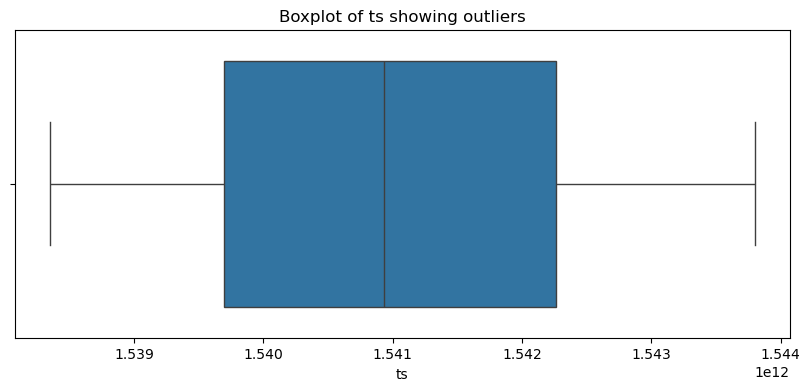


Outliers in status:
Lower bound: 200.00
Upper bound: 200.00
Number of outliers: 26688


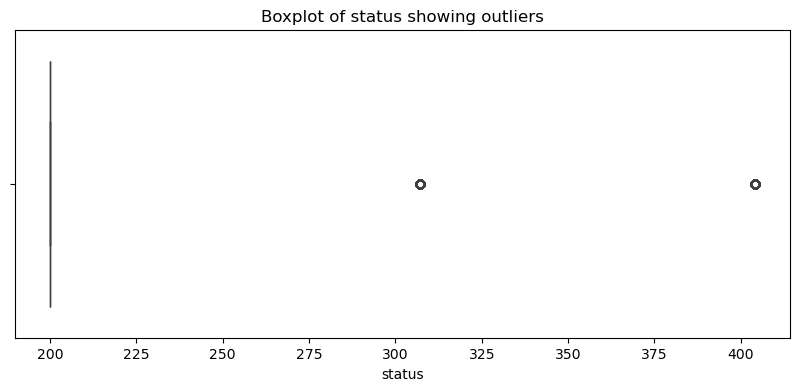


Outliers in itemInSession:
Lower bound: -166.88
Upper bound: 350.12
Number of outliers: 16852


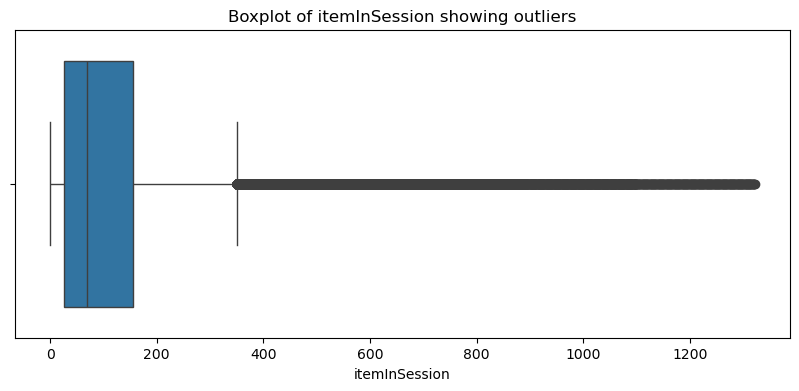


Outliers in registration:
Lower bound: 1526521947500.00
Upper bound: 1544308839500.00
Number of outliers: 3761


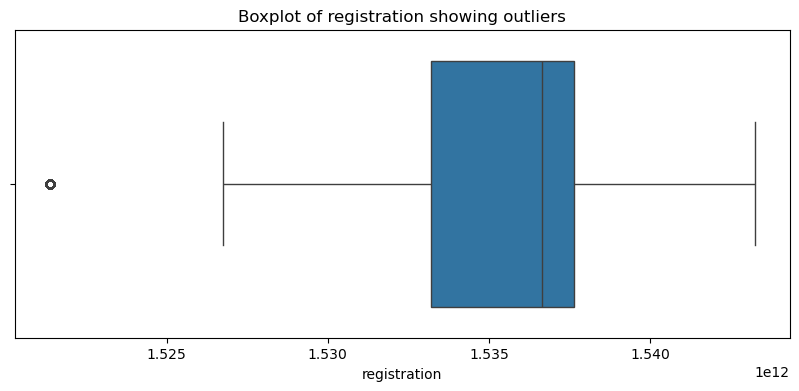


Outliers in length:
Lower bound: 127.02
Upper bound: 346.14
Number of outliers: 30174


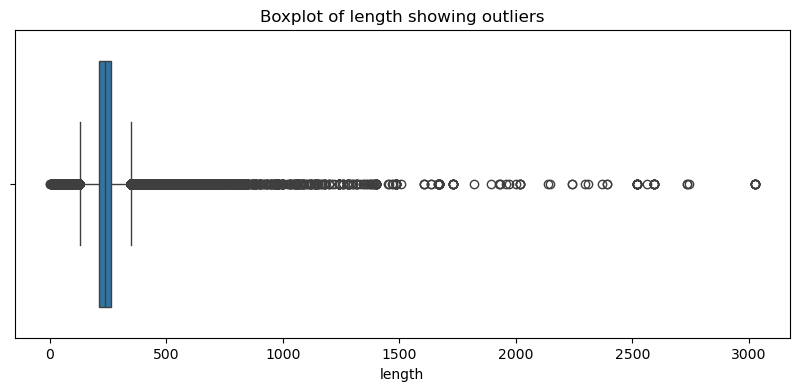

C:\Users\poosa\AppData\Local\Temp\ipykernel_14312\887637214.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-166.875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_no_outliers.loc[df_no_outliers[column] < lower_bound, column] = lower_bound


In [ ]:
# Identify numeric columns for outlier detection
numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col not in ['userId', 'sessionId']]

print("Outlier Analysis:")
print("-" * 50)
outlier_indices = detect_outliers(df_cleaned, numeric_columns)

# Remove outliers
df_no_outliers = remove_outliers(df_cleaned, numeric_columns)

In [49]:
# Create enhanced feature set
def create_features(df):
    user_features = df.groupby('userId').agg({
        'sessionId': 'nunique',
        'ts': 'count',
        'length': ['mean', 'std'],
        'page': lambda x: (x == 'Thumbs Up').sum(),
        'level': lambda x: x.iloc[-1],
        'artist': 'nunique',
        'song': 'nunique'
    })
    
    user_features.columns = [
        'total_sessions', 'total_actions', 'avg_song_length', 
        'std_song_length', 'thumbs_up_count', 'subscription_level',
        'unique_artists', 'unique_songs'
    ]
    
    user_features['songs_per_session'] = user_features['unique_songs'] / user_features['total_sessions']
    user_features['actions_per_session'] = user_features['total_actions'] / user_features['total_sessions']
    user_features['subscription_level'] = (user_features['subscription_level'] == 'paid').astype(int)
    
    return user_features

# Create feature set
user_features = create_features(df_no_outliers)

# Add churn label
churned_users = df_no_outliers[df_no_outliers['page'] == 'Cancellation Confirmation']['userId'].unique()
user_features['churned'] = user_features.index.isin(churned_users).astype(int)

print("Feature set shape:", user_features.shape)
print("\nFeatures created:", user_features.columns.tolist())
print("\nChurn rate: {:.2f}%".format(user_features['churned'].mean() * 100))

Feature set shape: (226, 11)

Features created: ['total_sessions', 'total_actions', 'avg_song_length', 'std_song_length', 'thumbs_up_count', 'subscription_level', 'unique_artists', 'unique_songs', 'songs_per_session', 'actions_per_session', 'churned']

Churn rate: 23.01%


In [51]:
# Preprocessing
# Assuming 'target' is the column you want to predict
X = df_cleaned.drop('target', axis=1)
y = df_cleaned['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Print classification report
print(classification_report(y_test, y_pred))

# Plot feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


KeyError: "['target'] not found in axis"

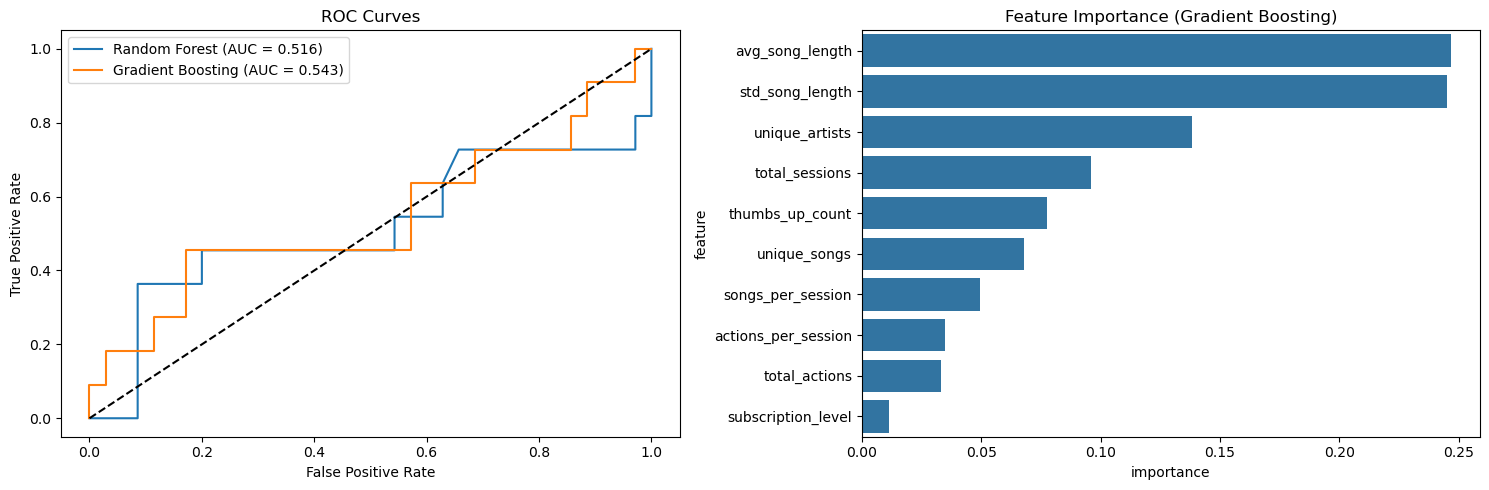

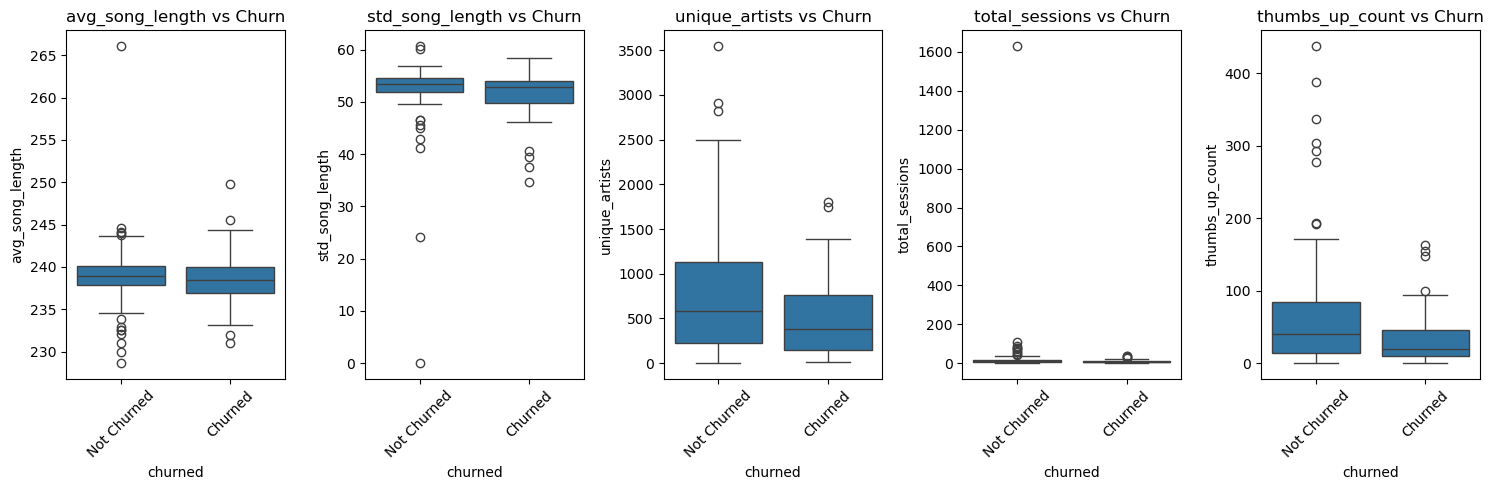


Key Insights about Churn Predictors:
--------------------------------------------------

avg_song_length:
- Churned users average: 238.51
- Non-churned users average: 238.97
- Difference: -0.2%

std_song_length:
- Churned users average: 51.38
- Non-churned users average: 52.61
- Difference: -2.3%

unique_artists:
- Churned users average: 519.69
- Non-churned users average: 746.47
- Difference: -30.4%

total_sessions:
- Churned users average: 10.33
- Non-churned users average: 24.53
- Difference: -57.9%

thumbs_up_count:
- Churned users average: 35.75
- Non-churned users average: 61.45
- Difference: -41.8%


In [ ]:
# Plot ROC curves and feature importance
plt.figure(figsize=(15, 5))

# ROC curve
plt.subplot(1, 2, 1)
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

# Feature importance
plt.subplot(1, 2, 2)
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model = models[best_model_name]

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title(f'Feature Importance ({best_model_name})')
plt.tight_layout()
plt.show()

# Analyze top predictors
top_features = feature_importance['feature'].head(5).tolist()

plt.figure(figsize=(15, 5))
for i, feature in enumerate(top_features, 1):
    plt.subplot(1, 5, i)
    sns.boxplot(x='churned', y=feature, data=user_features)
    plt.title(f'{feature} vs Churn')
    plt.xticks([0, 1], ['Not Churned', 'Churned'])
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print insights about top predictors
print("\nKey Insights about Churn Predictors:")
print("-" * 50)
for feature in top_features:
    avg_churned = user_features[user_features['churned'] == 1][feature].mean()
    avg_not_churned = user_features[user_features['churned'] == 0][feature].mean()
    diff_percent = ((avg_churned - avg_not_churned) / avg_not_churned) * 100
    
    print(f"\n{feature}:")
    print(f"- Churned users average: {avg_churned:.2f}")
    print(f"- Non-churned users average: {avg_not_churned:.2f}")
    print(f"- Difference: {diff_percent:+.1f}%")


User Behavior Metrics Comparison:
--------------------------------------------------

Before outlier handling:
       total_sessions  total_actions   page_views  avg_song_length     churned
count      226.000000     226.000000   226.000000       226.000000  226.000000
mean        21.261062    1267.699115  1267.699115       246.024831    0.230088
std        108.410077    1408.355459  1408.355459         4.786222    0.421824
min          1.000000       6.000000     6.000000       228.997839    0.000000
25%          6.000000     299.500000   299.500000       243.864410    0.000000
50%         10.000000     848.000000   848.000000       246.330973    0.000000
75%         18.000000    1878.000000  1878.000000       248.175302    0.000000
max       1629.000000    9632.000000  9632.000000       266.074102    1.000000

After outlier handling:
       total_sessions  total_actions   page_views  avg_song_length
count      226.000000     226.000000   226.000000       226.000000
mean        21.261

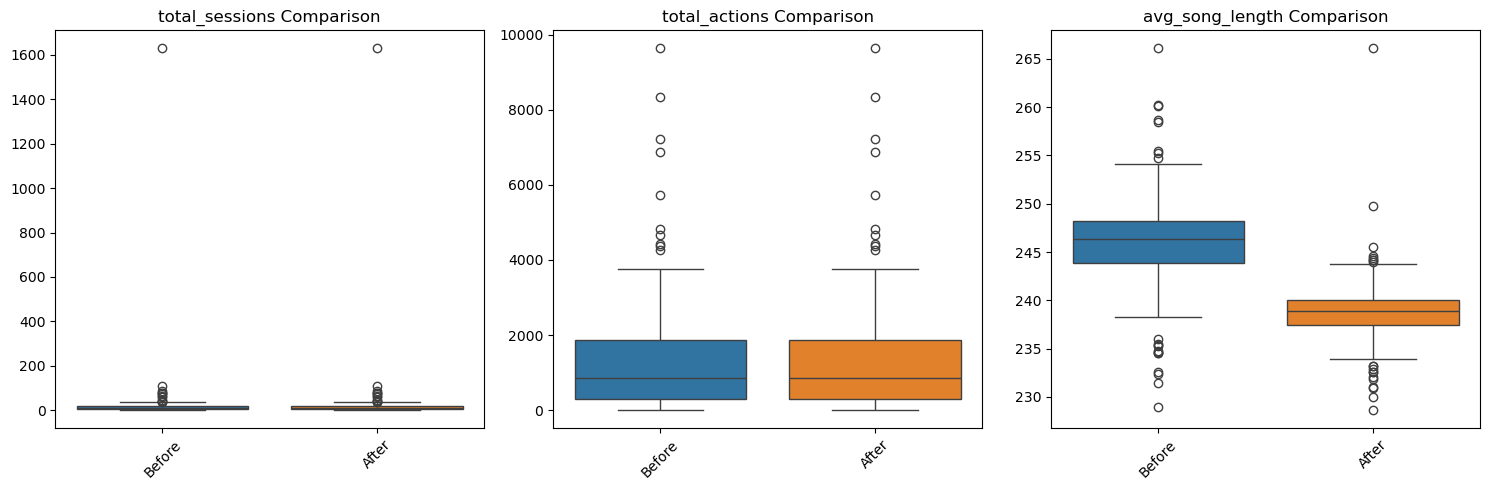

In [ ]:
# Recalculate user behavior metrics with outlier-handled data
user_behavior_no_outliers = df_no_outliers.groupby('userId').agg({
    'sessionId': 'nunique',
    'ts': 'count',
    'page': 'count',
    'length': 'mean'
}).rename(columns={
    'sessionId': 'total_sessions',
    'ts': 'total_actions',
    'page': 'page_views',
    'length': 'avg_song_length'
})

# Compare user behavior metrics before and after outlier handling
print("\nUser Behavior Metrics Comparison:")
print("-" * 50)
print("\nBefore outlier handling:")
print(user_behavior.describe())
print("\nAfter outlier handling:")
print(user_behavior_no_outliers.describe())

# Visualize the comparison
metrics = ['total_sessions', 'total_actions', 'avg_song_length']
plt.figure(figsize=(15, 5))

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=pd.DataFrame({
        'Before': user_behavior[metric],
        'After': user_behavior_no_outliers[metric]
    }))
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Update churn analysis with outlier-handled data
churned_users = df_no_outliers[df_no_outliers['page'] == 'Cancellation Confirmation']['userId'].unique()
user_behavior_no_outliers['churned'] = user_behavior_no_outliers.index.isin(churned_users).astype(int)

print("\nChurn Analysis After Outlier Handling:")
print("-" * 50)
print(f"Total Users: {len(user_behavior_no_outliers)}")
print(f"Churned Users: {len(churned_users)}")
print(f"Churn Rate: {(len(churned_users) / len(user_behavior_no_outliers)) * 100:.2f}%")

# Compare metrics between churned and non-churned users
print("\nBehavior Comparison After Outlier Handling (Mean Values):")
print(user_behavior_no_outliers.groupby('churned').mean())


Churn Analysis After Outlier Handling:
--------------------------------------------------
Total Users: 226
Churned Users: 52
Churn Rate: 23.01%

Behavior Comparison After Outlier Handling (Mean Values):
         total_sessions  total_actions   page_views  avg_song_length
churned                                                             
0             24.528736    1388.712644  1388.712644       238.972942
1             10.326923     862.769231   862.769231       238.513792
